In [1]:
import mysql.connector, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
cnx = mysql.connector.connect(user='dbuser', password='dbpass', database='zipcode')
cursor = cnx.cursor()

In [3]:
fields = ['population',
          'employment',
          'area',
          'hunits',
          'sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus',
          '2014_later',
          '2010_2013',
          '2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']
type_cat = ['sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus']
age_cat = ['2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']

In [4]:
cursor.execute("SELECT {0} FROM zip_housing;".format(", ".join(fields)))
rawdata = cursor.fetchall()
df = pd.DataFrame(rawdata, columns = fields)
df = df.drop(df[df.hunits==0].index) # remove rows with zero housing units!

In [5]:
sum(df['hunits']), sum(df[type_cat].sum(axis=0)), sum(df[['2014_later','2010_2013'] + age_cat].sum(axis=0))

(134913539, 126319534, 134913539)

Note that the number of housing units counted in the date ranges is not the same as the number of units counted by type!

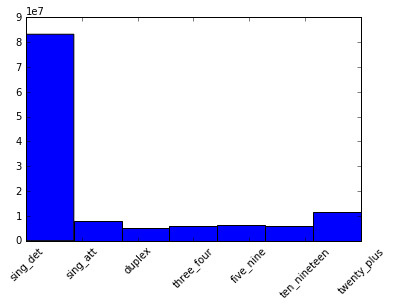

In [6]:
data = {k: v for k, v in enumerate(df[type_cat].sum(axis=0))}
ax = plt.subplot()
ax.hist(list(data.keys()), weights=list(data.values()), bins=7)
ax.set_xticklabels(type_cat, rotation=45)
plt.show()

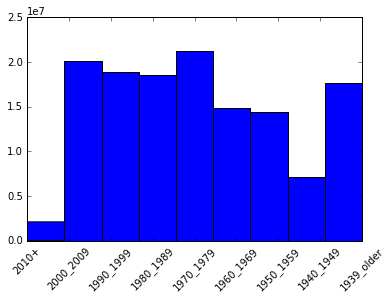

In [7]:
d = df.sum(axis=0)[-10:]
newd = np.hstack([[d[0] + d[1]], d[2:]]) # Combine 2010-2013 and 2014+ into one category
data = {k: v for k, v in enumerate(newd)}
ax = plt.subplot()
ax.hist(list(data.keys()), weights=list(data.values()), bins=9)
ax.set_xticklabels(['2010+'] + age_cat, rotation=45)
plt.show()

In [8]:
cat_data = np.empty((7, 8))
for i, row in enumerate(type_cat):
    for j, col in enumerate(age_cat):
        cat_data[i, j] = sum(df[row]*df[col]/df['hunits'])
trutab = pd.DataFrame(cat_data, index=type_cat, columns=age_cat, dtype=int)
trutab

,2000_2009,1990_1999,1980_1989,1970_1979,1960_1969,1950_1959,1940_1949,1939_older
sing_det,13231648,12383720,11622307,13186186,8981531,8881509,4171739,9434389
sing_att,1080944,1057279,1117296,1219262,876154,868056,460750,1147528
duplex,481991,451096,493335,639427,569156,650298,396436,1294500
three_four,672204,645731,725539,887440,686525,689152,380892,1204765
five_nine,825655,819087,911708,1061701,763556,704955,345267,925055
ten_nineteen,829216,805582,907553,1026481,719441,644608,296961,730331
twenty_plus,1456613,1206455,1436357,1784572,1436910,1335572,694701,2119241


Here are the results of a $\chi^2$ test of independence

In [9]:
chi2, p, dof, exps = stats.chi2_contingency(trutab)
exptab = pd.DataFrame(exps, index=type_cat, columns=age_cat, dtype=int)
chi2, p

(2146451.9082430019, 0.0)

With a $p$ value of 0 we can, with very high confidence, reject the hull hypothesis that building type and age are independent. 

In [10]:
(trutab - exptab)/exptab

,2000_2009,1990_1999,1980_1989,1970_1979,1960_1969,1950_1959,1940_1949,1939_older
sing_det,0.081682,0.082851,0.025414,0.011192,-0.027964,-0.020706,-0.060896,-0.149929
sing_att,-0.075460,-0.032738,0.031364,-0.021753,-0.007914,0.001407,0.085172,0.081787
duplex,-0.351559,-0.350869,-0.283700,-0.193041,0.013700,0.180006,0.468640,0.919507
three_four,-0.236247,-0.215243,-0.110320,-0.054156,0.032653,0.056105,0.191695,0.508725
five_nine,-0.130479,-0.077337,0.036236,0.048848,0.064558,0.001345,0.001261,0.073754
ten_nineteen,-0.068589,-0.032134,0.100188,0.081567,0.069833,-0.023414,-0.081489,-0.095832
twenty_plus,-0.149846,-0.246825,-0.095233,-0.022951,0.110271,0.051383,0.116509,0.363293


Looking at the individual building types, we can see that large apartment complexes were much more common before 1970, while single family homes were more common after. In particular, duplexes and three-four unit apartments were much more common before WWII, and much less common recently. 

In [11]:
bigpop = df#[df['population'] > 10000]
mode_map = pd.concat([bigpop[age_cat].idxmax(axis=1), (bigpop['population'])/bigpop['area'], bigpop['population']], axis=1)
mode_map.columns = ['age_mode', 'density', 'population']

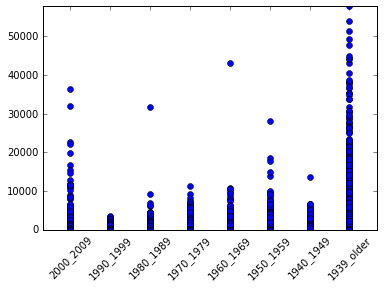

In [12]:
acmap = {name: i for i, name in enumerate(age_cat)}
ax = plt.subplot()
ax.plot([acmap[label] for label in mode_map['age_mode']], mode_map['density'], 'o')
plt.xticks(range(len(age_cat)), age_cat)
ax.margins(0.1, 0)
ax.set_xticklabels(age_cat, rotation=45)
plt.show()

In [13]:
rng = range(0, int(max(mode_map['density'])/100))
mode_1930 = mode_map[mode_map['age_mode'] == '1939_older'][['density', 'population']]
mode_1930['bin'] = pd.cut(mode_1930['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])

In [14]:
mode_2000 = mode_map[mode_map['age_mode'] == '2000_2009'][['density', 'population']]
mode_2000['bin'] = pd.cut(mode_2000['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])

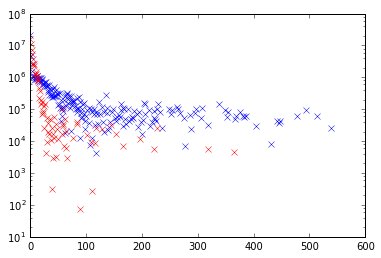

In [15]:
sums_1930 = [mode_1930[mode_1930['bin']==i]['population'].sum() for i in rng]
sums_2000 = [mode_2000[mode_2000['bin']==i]['population'].sum() for i in rng]
plt.semilogy([i for i in rng], sums_1930, 'bx', [i for i in rng], sums_2000, 'rx')
plt.show()